In [110]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support

In [22]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = ['highlights', 'highlights2', '.DS_Store']
dt = np.dtype([('a', float), ('b', float), ('name', np.unicode_, 16)])

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    if game_name != 'ned_svk':
        game_info = os.listdir(path)
        game_data = dict()
        for info in game_info:
            tag_name = os.path.splitext(info)[0]
            if tag_name not in tag_to_skip:
                csv_file = os.path.join(path, info)
                if tag_name == 'highlights_boundaries':
                    data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
                else:
                    data_value = np.fromfile(csv_file, dtype=np.float64)
                game_data[tag_name] = data_value
        game_data['name'] = game_name
        games_data.append(game_data)

games_backup = games_data[:]

In [3]:
games_data = games_backup[:]

In [24]:
### CRIANDO VETOR DE GT ###

normal_cases = ['Normal', 'Inicio', 'Fim']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    for line in h[:-1]:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][0]
        if name not in normal_cases:
            gt[line[0]-1:line[1]] = 1
    game['gt'] = gt
    del game['highlights_boundaries']

In [25]:
### REMOVENDO VALORES CORRELACIONADOS ###

to_remove = ['em_mcs_energy', 'em_mcs_energy_diff', 'em_mcs_energy_diff_ascending']
for game in games_data:
    for tag in to_remove:
        del game[tag]

In [26]:
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

In [27]:
### DIVIDING SPLITS FROM TRAIN, EVAL, TEST ###

from sklearn.model_selection import train_test_split

games_name = [g['name'] for g in games_data]
games_train1, games_test = train_test_split(games_name, test_size=0.15)
games_train2, games_val = train_test_split(games_train1, test_size=0.05)

print('Total train: {}'.format(len(games_train2)))
print('Total test: {}'.format(len(games_test)))
print('Total val: {}'.format(len(games_val)))

Total train: 22
Total test: 5
Total val: 2


In [96]:
for i, tag_name in enumerate(games_data[0].keys()):
    print('{} - {}'.format(i, tag_name))

0 - pc_var_theta
1 - em_st_energy
2 - pm_pitch
3 - em_cs_energy_diff_ascending
4 - pm_pitch_diff_ascending
5 - pc_theta
6 - name
7 - em_st_energy_diff
8 - pm_pitch_diff
9 - em_st_energy_diff_ascending
10 - em_cs_energy_diff
11 - pc_delta
12 - pc_rho
13 - gt
14 - dc_percent
15 - em_cs_energy
16 - dc_hue_mean
17 - pc_var_delta


In [75]:
name_id = 6
gt_id = 13

X_train = []
y_train = []

for game in games_data:
    if game['name'] in games_train1:
        values_array = np.array(list(game.values()))
        # Getting GT
        y_train += list(values_array[13])
        
        # Removing name and GT to train
        values_array = np.delete(values_array, (6), axis=0)
        values_array = np.delete(values_array, (13), axis=0)
        
        values_array = np.array(values_array[:].tolist())
        if len(X_train) == 0:
            X_train = np.transpose(values_array)
        else:
            X_train = np.concatenate((X_train, np.transpose(values_array)))

y_train = np.array(y_train)    


X_test = []
y_test = []

for game in games_data:
    if game['name'] in games_test:
        values_array = np.array(list(game.values()))
        # Getting GT
        y_test += list(values_array[13])
        
        # Removing name and GT to train
        values_array = np.delete(values_array, (6), axis=0)
        values_array = np.delete(values_array, (13), axis=0)
        
        values_array = np.array(values_array[:].tolist())
        if len(X_test) == 0:
            X_test = np.transpose(values_array)
        else:
            X_test = np.concatenate((X_test, np.transpose(values_array)))
y_test = np.array(y_test)
            

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (5278776, 16) (5278776,)
Test (1099745, 16) (1099745,)


In [111]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [112]:
y_predictions = clf.predict_proba(X_test)
y_score = clf.predict(X_test)

Average precision-recall score: 1.00
Precision: [ 1.  1.]
Recall: [ 1.  1.]


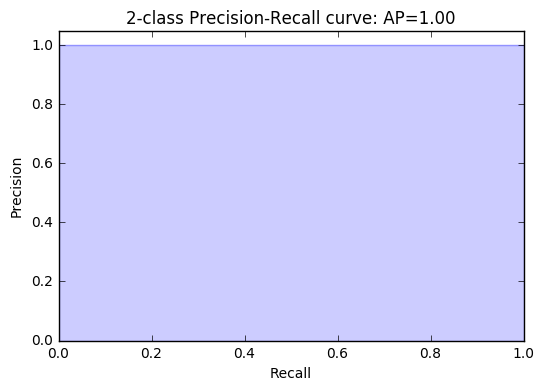

In [113]:
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

p_r_fs = precision_recall_fscore_support(y_test, y_score)
print('Precision: {}'.format(p_r_fs[0]))
print('Recall: {}'.format(p_r_fs[1]))

precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [117]:
new_keys = list(games_data[0].keys())
new_keys.remove('gt')
new_keys.remove('name')

for feature in range(X_train.shape[1]):
    new_X_train = X_train[:, feature]
    new_X_test = X_test[:, feature]
    print(new_X_train)
    
    start_time = time.clock()
    new_clf = RandomForestClassifier()
    new_clf.fit(new_X_train[:, None], y_train)
    
    new_y_score = new_clf.predict(new_X_test[:, None])
    new_average_precision = average_precision_score(y_test, new_y_score)
    new_p_r_fs = precision_recall_fscore_support(y_test, new_y_score)

    print(new_keys[feature])
    print('\tAverage precision-recall score: {0:0.2f}'.format(new_average_precision))
    print('\tPrecision: {}'.format(new_p_r_fs[0]))
    print('\tRecall: {}'.format(new_p_r_fs[1]))
    print('\tTime: {:.5f} seconds'.format(time.clock() - start_time))
    

[  4.85184465e-33   2.31575536e-52   3.85832361e-86 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pc_var_theta
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.81879 seconds
[  9.04921460e-043   4.18488602e-062   2.96899917e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


em_st_energy
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.81552 seconds
[  4.16304064e-245   3.85591683e-057   6.00888578e-067 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pm_pitch
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 13.95709 seconds
[  2.96620797e-260   2.96620797e-260   2.96620797e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


em_cs_energy_diff_ascending
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.76949 seconds
[  2.96620797e-260   2.96620797e-260   2.96620797e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pm_pitch_diff_ascending
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.85867 seconds
[  2.96620797e-260   2.96620797e-260   5.76755035e-245 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pc_theta
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.76564 seconds
[  4.17636288e-062   8.61115299e-067   2.96660805e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


em_st_energy_diff
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.60566 seconds
[  5.31345130e-245   4.66150860e-033   4.67009164e-062 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pm_pitch_diff
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 13.85853 seconds
[  2.96620797e-260   2.96620797e-260   2.96620797e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


em_st_energy_diff_ascending
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.58986 seconds
[  1.57610813e-52   9.95279112e-43   4.42131876e-62 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


em_cs_energy_diff
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 13.05413 seconds
[  2.96620797e-260   2.96620797e-260   2.96661426e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pc_delta
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.76549 seconds
[  2.96620797e-260   2.96620797e-260   2.96939461e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pc_rho
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.50106 seconds
[ 0.  0.  0. ...,  0.  0.  0.]
dc_percent
	Average precision-recall score: 1.00
	Precision: [ 1.  1.]
	Recall: [ 1.  1.]
	Time: 12.63918 seconds
[  1.57692220e-52   9.73449964e-72   1.74451393e-76 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


em_cs_energy
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.88499 seconds
[  3.70980754e-245   4.91035163e-062   4.91127896e-062 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


dc_hue_mean
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.88176 seconds
[  2.96900070e-260   2.96701280e-260   2.96898832e-260 ...,
   0.00000000e+000   0.00000000e+000   0.00000000e+000]
pc_var_delta
	Average precision-recall score: 0.51
	Precision: [ 0.98706427  0.        ]
	Recall: [ 1.  0.]
	Time: 12.54316 seconds


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
new_keys = list(games_data[0].keys())
new_keys.remove('gt')
new_keys.remove('name')

for feature1 in range(X_train.shape[1]):
    new_X_train1 = X_train[:, feature1]
    new_X_test1 = X_test[:, feature1]
    for feature2 in range(feature1, X_train.shape[1]):
        new_X_train2 = X_train[:, feature2]
        new_X_test2 = X_test[:, feature2]
        
        new_X_train = np.concatenate((new_X_train1, new_X_train2), axis=0)
        
        print(new_X_train.shape)
        raise Exception

        start_time = time.clock()
        new_clf = RandomForestClassifier()
        new_clf.fit(new_X_train[:, None], y_train)

        new_y_score = new_clf.predict(new_X_test[:, None])
        new_average_precision = average_precision_score(y_test, new_y_score)
        new_p_r_fs = precision_recall_fscore_support(y_test, new_y_score)

        print(new_keys[feature])
        print('\tAverage precision-recall score: {0:0.2f}'.format(new_average_precision))
        print('\tPrecision: {}'.format(new_p_r_fs[0]))
        print('\tRecall: {}'.format(new_p_r_fs[1]))
        print('\tTime: {:.5f} seconds'.format(time.clock() - start_time))

(10557552,)


Exception: 

In [102]:
new_keys

['pc_var_theta',
 'em_st_energy',
 'pm_pitch',
 'em_cs_energy_diff_ascending',
 'pm_pitch_diff_ascending',
 'pc_theta',
 'em_st_energy_diff',
 'pm_pitch_diff',
 'em_st_energy_diff_ascending',
 'em_cs_energy_diff',
 'pc_delta',
 'pc_rho',
 'dc_percent',
 'em_cs_energy',
 'dc_hue_mean',
 'pc_var_delta']